Here we develop code to fit latent regression models to data with priors on the projection matrices

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from janelia_core.ml.extra_torch_modules import Bias
from janelia_core.ml.extra_torch_modules import ConstantBoundedFcn
from janelia_core.ml.extra_torch_modules import IndSmpConstantBoundedFcn
from janelia_core.ml.extra_torch_modules import IndSmpConstantRealFcn
from janelia_core.ml.extra_torch_modules import LogGaussianBumpFcn
from janelia_core.ml.extra_torch_modules import SumOfTiledHyperCubeBasisFcns

from janelia_core.ml.latent_regression import GroupMatrixMultiply
from janelia_core.ml.latent_regression import GroupScalarTransform
from janelia_core.ml.latent_regression import LatentRegModel
from janelia_core.ml.latent_regression import LinearMap
from janelia_core.ml.latent_regression import IdentityMap
from janelia_core.ml.latent_regression import vae_fit_latent_reg_model

from janelia_core.ml.torch_distributions import CondBernoulliDistribution
from janelia_core.ml.torch_distributions import CondGaussianDistribution
from janelia_core.ml.torch_distributions import CondSpikeSlabDistribution

from janelia_core.visualization.matrix_visualization import cmp_n_mats

## Parameters go here

In [3]:
n_neurons = [1000]

d_in = n_neurons
d_out = n_neurons

d_proj = [2]
d_trans = [2]

n_smps = 1000

device = 'cpu' # Device to perform fitting on

## Helper functions for visualization

In [4]:
def visualize_mode_mean(d, x_range = [0.0, .999], y_range = [0.0, .999], n_points_per_side=100):

    orig_device = next(d.parameters()).device
    
    d = d.to('cpu') # Make a copy of model on cpu
    
    grid = np.mgrid[x_range[0]:x_range[1]:n_points_per_side * 1j,
           y_range[0]:y_range[1]:n_points_per_side * 1j]

    grid_vec = np.stack([np.ravel(grid[0, :, :]), np.ravel(grid[1, :, :])]).transpose()
    grid_vec = torch.from_numpy(grid_vec.astype('float32'))

    mn_vec = d(grid_vec).detach().numpy()
    mn_image = np.reshape(mn_vec, [n_points_per_side, n_points_per_side])
    
    plt.imshow(mn_image, extent=[x_range[0], x_range[1], y_range[0], y_range[1]], origin='lower')
    plt.colorbar()
    
    d = d.to(orig_device)

def visualize_mode_pairs(d1, d2, x_range = [0.0, .999], y_range = [0.0, .999], n_points_per_side=100):
      
    n_modes = len(d1)    
    
    plt.figure()
    
    for m_i in range(n_modes):
            
        # Plot d1 modes in top row
        plt.subplot(2, n_modes, m_i+1)
        visualize_mode_mean(d1[m_i], x_range=x_range, y_range=y_range, n_points_per_side=n_points_per_side)
        
        # Plot d2 modes in second row
        plt.subplot(2, n_modes, m_i+1 + n_modes)
        visualize_mode_mean(d2[m_i], x_range=x_range, y_range=y_range, n_points_per_side=n_points_per_side)

## Define the true conditional priors on mode weights

In [5]:
n_grps = len(n_neurons)

In [6]:
# Spike and slab modes

n_prior_nodes = 20

true_prior_p_dists = [None]*n_grps
true_prior_u_dists = [None]*n_grps

for g in range(n_grps):

    n_grp_modes = [d_proj[g], d_trans[g]]
    for i in range(2):
        # Iterate over p and u modes
        n_cur_modes = n_grp_modes[i]
        proj_mode_dists = [None]*n_cur_modes
        for mode_i in range(n_cur_modes):
            
            spike_log_prob_fcn = LogGaussianBumpFcn(d_x=2, ctr_std_init=0.25, log_gain_init=-0.00001)
            spike_d = CondBernoulliDistribution(spike_log_prob_fcn)
            
            slab_mn_fcn = torch.nn.Sequential(torch.nn.Linear(2,n_prior_nodes), torch.nn.ReLU(), 
                                              torch.nn.Linear(n_prior_nodes, n_prior_nodes), torch.nn.ReLU(), 
                                              torch.nn.Linear(n_prior_nodes,1))
            slab_mn_fcn[4].weight.data = 10*slab_mn_fcn[4].weight.data
            
            slab_std_fcn = ConstantBoundedFcn(lower_bound=np.asarray([.001]), upper_bound=np.asarray([10]), 
                                        init_value=np.asarray(.01))
            
            slab_d = CondGaussianDistribution(mn_f=slab_mn_fcn, std_f=slab_std_fcn)
     
            proj_mode_dists[mode_i] = CondSpikeSlabDistribution(d=1, spike_d=spike_d, slab_d=slab_d)
        
        if i == 0:
            true_prior_p_dists[g] = proj_mode_dists
        else:
            true_prior_u_dists[g] = proj_mode_dists

In [7]:
# Group the true priors by group (so that distributions for p and u modes are together) for convenience
true_prior_mode_dists = list(zip(true_prior_p_dists, true_prior_u_dists))

## Visualize the means of the true distributions on weights

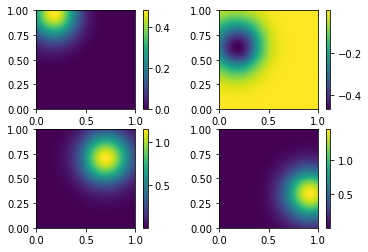

In [8]:
for g in range(n_grps):
        visualize_mode_pairs(true_prior_p_dists[g], true_prior_u_dists[g])

## Generate neuron properties

In [9]:
neuron_props = [torch.zeros(n_neurons[g], 2).uniform_() for g in range(n_grps)]

## Generate true mode weights from the prior that was just defined 

In [10]:
true_p = [None]*n_grps
true_u = [None]*n_grps

for g in range(n_grps):
    n_grp_neurons = n_neurons[g]
    n_grp_modes = [d_proj[g], d_trans[g]]
    
    for i in range(2):
        n_cur_modes = n_grp_modes[i]
        mode_mat = torch.zeros(n_grp_neurons, n_cur_modes)
        for mode_i in range(n_cur_modes):
            mode_mat[:, mode_i] = true_prior_mode_dists[g][i][mode_i].form_standard_sample(
                true_prior_mode_dists[g][i][mode_i].sample(neuron_props[g])).squeeze()
        if i == 0:
            # P modes
            true_p[g] = mode_mat
        else:
            # U modes
            true_u[g] = mode_mat

# Define the true subject model

In [11]:
n_output_groups = len(d_in)

M = IdentityMap()
S = [Bias(d_o) for d_o in d_out]
mdl = LatentRegModel(d_in, d_out, d_proj, d_trans, M, S, direct_pairs=None, noise_range=[.25, .255])

for g, p_g in enumerate(mdl.p):
    p_g.data = true_p[g]
for h, u_h in enumerate(mdl.u):
    u_h.data = true_u[h]

## Generate data

In [12]:
x = [torch.randn([n_smps, d]) for d in d_in]
y = mdl.generate(x)

## Define the subject model we will fit

In [13]:
m_f = IdentityMap() 
#m_f = GroupScalarTransform(d=d_proj)
#m_f = GroupMatrixMultiply(d_in=d_proj, d_out=d_trans)
s_f = [Bias(d_o) for d_o in d_out]
subject_mdl_f = LatentRegModel(d_in, d_out, d_proj, d_trans, m_f, s_f, direct_pairs=None, assign_p_u=False)
subject_mdl_f = subject_mdl_f.to(device)

## Define the inference distribution (  $Q(l, r)$  ) that we will use

In [14]:
q_p_mode_dists = [None]*n_grps
q_u_mode_dists = [None]*n_grps

for g in range(n_grps):
    n_grp_neurons = n_neurons[g]
    for i in range(2):
        if i == 0:
            n_grp_modes = d_proj[g]
        else:
            n_grp_modes = d_trans[g]
    
        q_dists = [None]*n_grp_modes
        
        for mode_i in range(n_grp_modes):
            mn_f = IndSmpConstantRealFcn(n_grp_neurons, init_value=.01)
            std_f = IndSmpConstantBoundedFcn(n_grp_neurons, lower_bound=.0001, upper_bound=10.0, init_value=.2)
            q_dists[mode_i] = CondGaussianDistribution(mn_f=mn_f, std_f=std_f)
            q_dists[mode_i] = q_dists[mode_i].to(device)
        
        if i == 0:
            q_p_mode_dists[g] = q_dists
        else:
            q_u_mode_dists[g] = q_dists

## Define the conditional prior distribution (  $P(l,r|m)$  ) we will fit

In [15]:
class ExpModule(torch.nn.Module):
    def forward(self, x):
        return torch.exp(x) + .01

In [16]:
n_fit_prior_nodes = 100
n_fit_std_prior_nodes = 100

prior_p_dists = [None]*n_grps
prior_u_dists = [None]*n_grps

for g in range(n_grps):
    n_grp_neurons = n_neurons[g]
    for i in range(2):
        if i == 0:
            n_grp_modes = d_proj[g]
        else:
            n_grp_modes = d_trans[g]
            
        prior_dists = [None]*n_grp_modes
        
        for mode_i in range(n_grp_modes):
            #mn_fcn = torch.nn.Sequential(torch.nn.Linear(2,n_fit_prior_nodes), torch.nn.ReLU(), 
             #                                 torch.nn.Linear(n_fit_prior_nodes, n_fit_prior_nodes), torch.nn.ReLU(), 
             #                                 torch.nn.Linear(n_fit_prior_nodes,1))
            #mn_fcn[4].weight.data = 50*mn_fcn[4].weight.data
            
            #std_fcn = torch.nn.Sequential(torch.nn.Linear(2,n_fit_std_prior_nodes), torch.nn.ReLU(), 
            #                                  torch.nn.Linear(n_fit_std_prior_nodes, n_fit_std_prior_nodes), torch.nn.ReLU(), 
             #                                 torch.nn.Linear(n_fit_std_prior_nodes,1), ExpModule())
            
            n_divs_per_dim = [20, 20]
            dim_ranges = np.asarray([[0, 1.0], [0, 1.0]])
            n_div_per_bump_per_dim = np.asarray([2, 5], dtype='int')
            
            mn_fcn = SumOfTiledHyperCubeBasisFcns(n_divs_per_dim, dim_ranges, n_div_per_bump_per_dim)
            
            std_fcn = ConstantBoundedFcn(lower_bound=np.asarray([.001]), upper_bound=np.asarray([10]), 
                                        init_value=np.asarray(.01))
            
            prior_dists[mode_i] = CondGaussianDistribution(mn_f=mn_fcn, std_f=std_fcn)
            prior_dists[mode_i] = prior_dists[mode_i].to(device)
        
        if i == 0:
            prior_p_dists[g] = prior_dists
        else:
            prior_u_dists[g] = prior_dists

## Send data to device (if it is small enough)

In [17]:
if n_smps <= 1000:
    x = [x_g.to(device) for x_g in x]
    y = [y_h.to(device) for y_h in y]

## Fit everything with variational inference

In [18]:
log = vae_fit_latent_reg_model(l_mdl = subject_mdl_f, q_p_dists=q_p_mode_dists, q_u_dists=q_u_mode_dists, 
                             prior_p_dists=prior_p_dists, prior_u_dists=prior_u_dists, learning_rates = .02,
                             x=x, y=y, x_props=neuron_props, batch_size = 1000, send_size = 1000, update_int=200, 
                             max_its=3000, min_var=.00001, fit_priors=True)

It: 0: Elapsed fitting time 2.193450927734375e-05, elbo: -243139923.28125, lr: 0.02, GPU mem. usage: nan bytes
    ll: -242342704.0, kl_p_sum: 386369.921875, kl_u_sum: 410849.359375
It: 200: Elapsed fitting time 5.304180860519409, elbo: -5019907.962890625, lr: 0.02, GPU mem. usage: nan bytes
    ll: -4997919.5, kl_p_sum: 11678.00048828125, kl_u_sum: 10310.46240234375
It: 400: Elapsed fitting time 10.432383060455322, elbo: -3352328.8110351562, lr: 0.02, GPU mem. usage: nan bytes
    ll: -3337145.5, kl_p_sum: 8035.927734375, kl_u_sum: 7147.38330078125
It: 600: Elapsed fitting time 15.525617122650146, elbo: -2788486.1733398438, lr: 0.02, GPU mem. usage: nan bytes
    ll: -2773781.0, kl_p_sum: 7877.3603515625, kl_u_sum: 6827.81298828125
It: 800: Elapsed fitting time 20.800724029541016, elbo: -2488596.2556152344, lr: 0.02, GPU mem. usage: nan bytes
    ll: -2473459.0, kl_p_sum: 8103.085205078125, kl_u_sum: 7034.17041015625


KeyboardInterrupt: 

In [ ]:
plt.plot(log['elapsed_time'], log['elbo'])

In [ ]:
vis_g = 0

true_w = torch.matmul(true_u[vis_g], true_p[vis_g].t()).detach().numpy()

est_p = [d.sample(neuron_props[vis_g]) for d in q_p_mode_dists[vis_g]]
est_p = torch.cat(est_p, dim=1)
#esp_p = torch.matmul(est_p, m_f.w[vis_g])
#est_p = est_p*m_f.v[vis_g]

est_u = [d.sample(neuron_props[vis_g]) for d in q_u_mode_dists[vis_g]]
est_u = torch.cat(est_u, dim=1)

est_w = torch.matmul(est_u, est_p.t()).detach().cpu().numpy()

cmp_n_mats([true_w, est_w, true_w-est_w], show_colorbars=True)


In [ ]:
vis_g = 0

In [ ]:
visualize_mode_pairs(true_prior_p_dists[vis_g], prior_p_dists[vis_g])

In [ ]:
visualize_mode_pairs(true_prior_u_dists[vis_g], prior_u_dists[vis_g])

In [ ]:
prior_u_dists[0]

In [ ]:
a = torch.tensor([[1.0, 2], [3, 4]])

In [ ]:
a

In [ ]:
b = torch.tensor([1.0, 2.0])

In [ ]:
b.shape

In [ ]:
a*b